<a href="https://colab.research.google.com/github/jimmy-pink/computer-science-manual/blob/main/Database%20Middleware/Mysql.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MYSQL架构

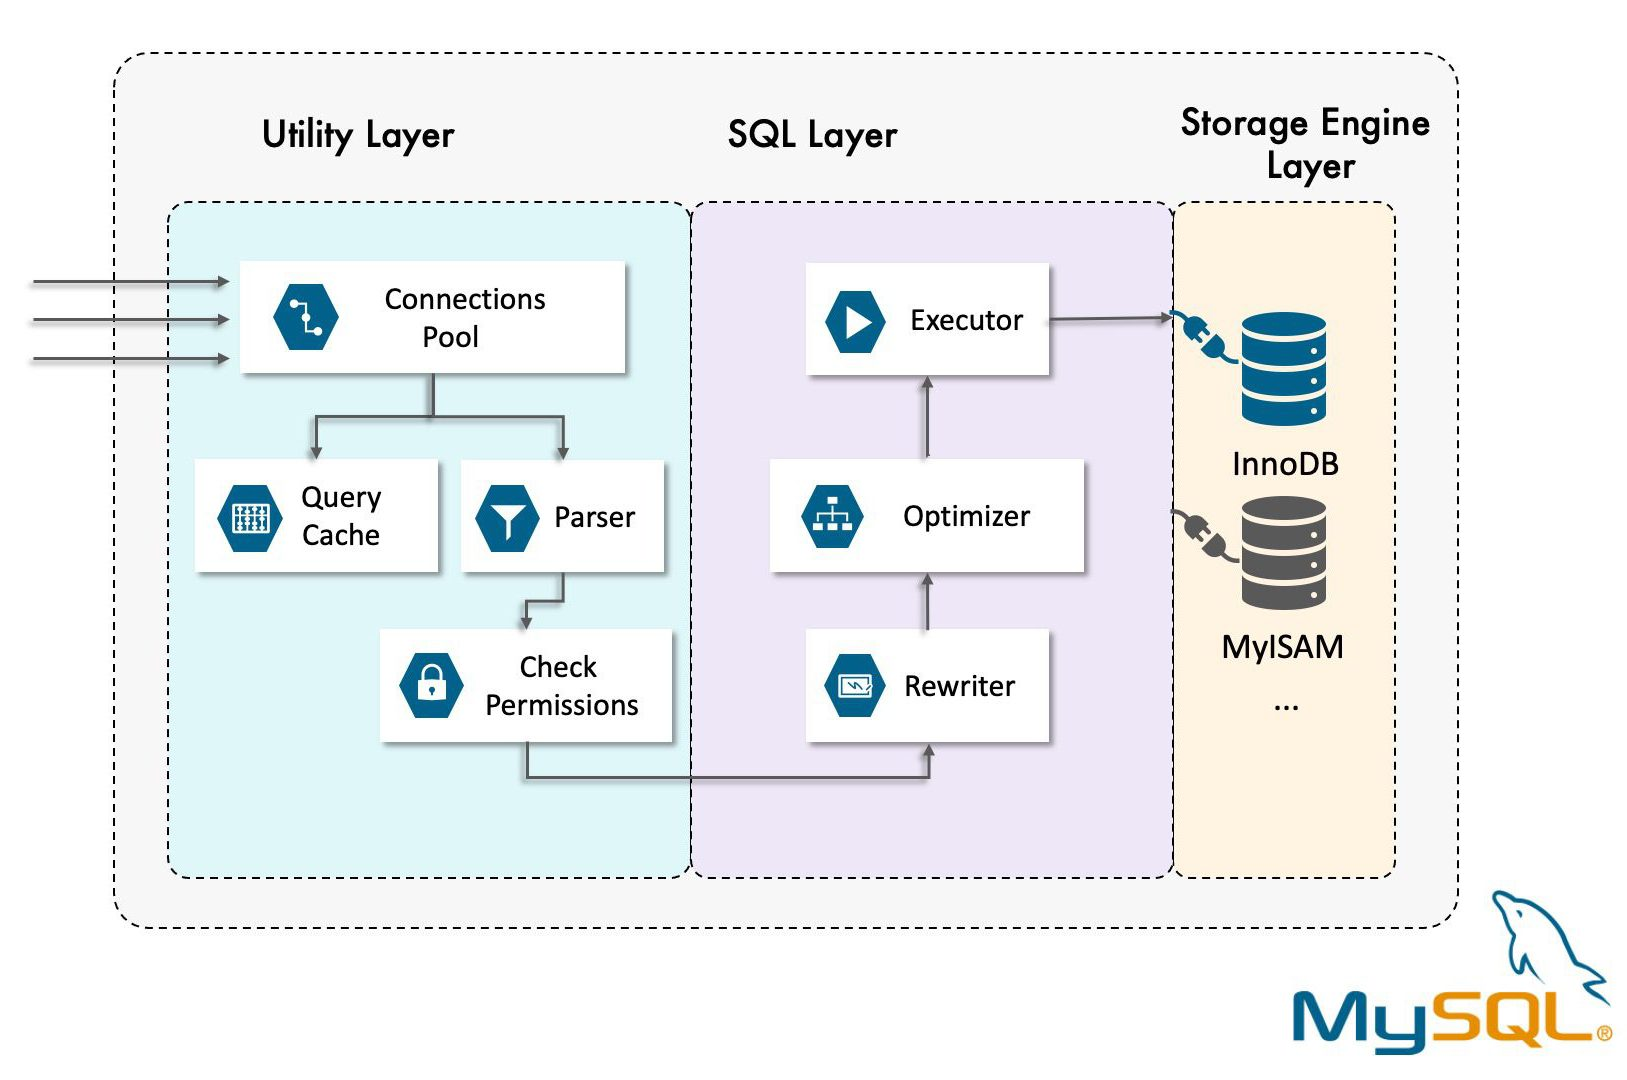

**Connector** 连接器，处理连接请求， 管理连接 和验证身份。

**Query Cache**  
MySQL 8.0以后移除了QueryCache，原因有：  
- 在高并发写场景下性能不佳
- 使用了Global Mutex(全局锁)，高并发场景下严重阻碍性能
- 现代高速缓存，如Redis, 应用本地缓存完全可以替代

**Parser** 语法和词法分析。   
**Preprocessor** 验证表名，列表，和crud权限。  
**Optimizer** 生成最优执行计划，包括索引选择，表顺序，连接类型
- ReWriter : 等价转换，子查询优化， 谓词下推

## 日志系统

## 存储引擎